In [1]:
import os
import time
import warnings
import numpy as np
import cvxpy as cp
import pandas as pd
from tqdm import tqdm
from scipy.linalg import orth
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
from matplotlib.ticker import LogFormatter
np.random.seed(100)
warnings.filterwarnings("ignore")

In [2]:
def generate_action_set(d):
    
    complete_rating = pd.read_csv('complete_ratings').values[:, 1:] / 5
    
    model = NMF(n_components = d, init = 'nndsvda', max_iter = 10000)
    W = model.fit_transform(complete_rating)
    H = model.components_
    W = W[:100]
    H = H[:, :100]
    
    A = np.zeros((W.shape[0], H.shape[1], d))
    Theta = np.zeros((d, W.shape[0]))
    
    for i in range(W.shape[0]):
    
        Theta[:, i] = np.ones(d) / np.linalg.norm(np.ones(d))
        
        for j in range(H.shape[1]):
    
            A[i, j] = W[i] * H[:, j] * np.linalg.norm(np.ones(d))

    L_list = []

    for i in range(W.shape[0]):

        norm_list = np.linalg.norm(A[-1], axis=1)
        L_list.append(norm_list)

    L = np.max(L_list)
    S = np.linalg.norm(Theta[:, -1])
                
    return A, Theta, L, S

In [3]:
def init_altgdmin(X, t, Y, C, M, d, k):
    
    alpha = C * np.linalg.norm(Y, 'fro') / np.sqrt(t * M)
    Y_trunc = np.where(np.abs(Y) > alpha, 0, Y)
    
    Theta_0 = np.zeros((d, M))
    
    for i in range(M):
        
        Theta_0[:, i] = np.sum(X[i].dot(np.diag(Y_trunc[i])), axis=1) / t
    
    U_0, Sigma_0, V_0 = np.linalg.svd(Theta_0, full_matrices = False)
    
    return U_0[:, :k]

In [4]:
def get_beta_our(sigma, k, n, L, ld, delta, S, N):

    beta = sigma * np.sqrt(k * np.log((1 + n * np.square(L) / ld) / delta)) + ((1 + delta_0) * np.sqrt(ld) + 2 * np.sqrt(n) * L * delta_0) * S
    # beta = sigma * np.sqrt(k * np.log((1 + n * np.square(L) / ld) / delta)) + (np.sqrt(ld) + np.sqrt(ld / N) / L + 2 * np.sqrt(n / N)) * S
    
    return beta

In [5]:
def get_beta_ohter_estimator(sigma, k, n, L, ld, delta, S, delta_0):
    
    beta = sigma * np.sqrt(k * np.log((1 + n * np.square(L) / ld) / delta)) + ((1 + delta_0) * np.sqrt(ld) + 2 * np.sqrt(n) * L * delta_0) * S
    
    return beta

In [6]:
def get_beta_Abbasi(sigma, k, n, L, ld, delta, S):
    
    beta = sigma * np.sqrt(k * np.log((1 + n * np.square(L) / ld) / delta)) + np.sqrt(ld) * S
    
    return beta

In [7]:
# cvxpy
def get_decision(action_set, theta_hat, V, beta, d):

    theta_list = []
    reward_list = []
    
    for action in action_set: 
    
        V_psd = cp.psd_wrap(V)
        theta = cp.Variable(d)
        objective = cp.Maximize(action.T @ theta)
        constraint = cp.quad_form(theta - theta_hat, V_psd) <= beta ** 2
        
        problem = cp.Problem(objective, [constraint])
        problem.solve(solver=cp.ECOS)
    
        # print(problem.status)
        
        theta_list.append(theta.value)
        reward_list.append(action.dot(theta.value))
    
    decision = np.argmax(reward_list)
    theta_tilde = theta_list[decision]
    
    return decision, theta_tilde

In [8]:
CR_Trials = []
CR_Trials_Abbasi = []
CR_Trials_MOM = []
d = 5
k = 1
C = 1
ld = 1
delta = 1e-3
sigma = 1e-1
every_point_plot = 50
every_point_scatter = 500
epoch_iter = 3000
epoch_iter_2 = 3000
iterations = epoch_iter + epoch_iter_2
A, Theta, L, S = generate_action_set(d)
M = A.shape[0]-1

In [9]:
# generate the noise of reward for each iteration
noise_list = np.random.normal(0, sigma ** 2, size = (iterations, M+1))

In [10]:
# Our Algorithm
start = time.time()

action_set = A
Theta_star = Theta
noise_T = noise_list

B_hat = np.zeros((d, k))
W_hat = np.zeros((k, M))
Theta_hat = B_hat.dot(W_hat)
w_hat = np.zeros(k)
theta_hat = B_hat.dot(w_hat)

cumulative_regret = 0
cummulative_regret_list = []

X = np.zeros((M, d, epoch_iter))
Y = np.zeros((M, epoch_iter))

V = ld * np.eye(d)
U = np.zeros((k, 1))
    
for t in range(epoch_iter):
    
    for i in range(M):
        
        action = np.argmax(np.dot(action_set[i], Theta_hat[:, i]))
        reward = action_set[i, action].dot(Theta_star[:, i])
        
        X[i, :, t] = action_set[i, action]
        Y[i, t] = reward + noise_T[t, i]
        
B_hat = init_altgdmin(X, epoch_iter, Y, C, M, d, k)
B_star, _, _ = np.linalg.svd(Theta_star, full_matrices = False)
delta_0 = np.linalg.norm((np.eye(d)-B_star.dot(B_star.T)).dot(B_hat), ord='fro')
print('subspace distance error is:', delta_0)

for t in tqdm(range(epoch_iter, iterations), desc = 'iterations'):

    beta = get_beta_our(sigma, k, t - epoch_iter + 1, L, ld, delta, S, iterations - epoch_iter)
    decision, theta_tilde = get_decision(action_set[-1], theta_hat, V, beta, d)

    reward = action_set[-1, decision].dot(Theta_star[:, -1])
    cumulative_regret += np.max(np.dot(action_set[-1], Theta_star[:, -1])) - reward

    V += action_set[-1, decision].reshape(-1, 1).dot(action_set[-1, decision].reshape(1, -1))
    U += B_hat.T.dot(action_set[-1, decision].reshape(-1, 1)) * (reward + noise_T[t, -1])
    w_hat = np.linalg.inv(B_hat.T.dot(V).dot(B_hat)).dot(U).reshape(-1)
    theta_hat = B_hat.dot(w_hat)
    
    cummulative_regret_list.append(cumulative_regret)
    # print('parameter error is {} and cumulative regret is {}'.format(np.linalg.norm(Theta_hat[:, i]-Theta_star[:, i]), cumulative_regret))
        
CR_Trials = cummulative_regret_list
    
end = time.time()
print('Finished! The total time we use is: ', end - start)

subspace distance error is: 4.578839103469418e-16


iterations: 100%|██████████| 3000/3000 [19:30<00:00,  2.56it/s]

Finished! The total time we use is:  1174.0990662574768


In [11]:
# Abbasi Algorithm
start = time.time()

action_set = A
Theta_star = Theta
noise_T = noise_list

theta_hat = np.zeros(d)

cumulative_regret = 0
cummulative_regret_list = []

V = ld * np.eye(d)
U = np.zeros((d, 1))

for t in tqdm(range(epoch_iter, iterations), desc = 'iterations'):

    beta = get_beta_Abbasi(sigma, d, t - epoch_iter + 1, L, ld, delta, S)
    decision, theta_tilde = get_decision(action_set[-1], theta_hat, V, beta, d)

    reward = action_set[-1, decision].dot(Theta_star[:, -1])
    cumulative_regret += np.max(np.dot(action_set[-1], Theta_star[:, -1])) - reward

    V += action_set[-1, decision].reshape(-1, 1).dot(action_set[-1, decision].reshape(1, -1))
    U += action_set[-1, decision].reshape(-1, 1) * (reward + noise_T[t, -1])
    theta_hat = np.linalg.inv(V).dot(U).reshape(-1)
    
    cummulative_regret_list.append(cumulative_regret)
    # print('cumulative regret is {}'.format(cumulative_regret))
        
CR_Trials_Abbasi = cummulative_regret_list
    
end = time.time()
print('Finished! The total time we use is: ', end - start)

iterations: 100%|██████████| 3000/3000 [19:13<00:00,  2.60it/s]

Finished! The total time we use is:  1153.6542475223541


In [12]:
# MOM
start = time.time()

action_set = A
Theta_star = Theta
noise_T = noise_list

B_hat = np.zeros((d, k))
W_hat = np.zeros((k, M))
Theta_hat = B_hat.dot(W_hat)
w_hat = np.zeros(k)
theta_hat = B_hat.dot(w_hat)

cumulative_regret = 0
cummulative_regret_list = []

M_hat = np.zeros((d, d))
V = ld * np.eye(d)
U = np.zeros((k, 1))

for t in range(epoch_iter):
    
    for i in range(M):
        
        action = np.argmax(np.dot(action_set[i], Theta_hat[:, i]))
        reward = action_set[i, action].dot(Theta_star[:, i])

        M_hat += (reward + noise_T[t, i]) ** 2 * np.dot(action_set[i, action].reshape(-1, 1), action_set[i, action].reshape(1, -1))

M_hat /= epoch_iter * M
B_hat = np.linalg.svd(M_hat, full_matrices=False)[0][:, :k]
B_star, _, _ = np.linalg.svd(Theta_star, full_matrices = False)
delta_0 = np.linalg.norm((np.eye(d)-B_star.dot(B_star.T)).dot(B_hat), ord='fro')
print('subspace distance error is:', delta_0)

for t in tqdm(range(epoch_iter, iterations), desc = 'iterations'):

    beta = get_beta_ohter_estimator(sigma, k, t - epoch_iter + 1, L, ld, delta, S, delta_0)
    decision, theta_tilde = get_decision(action_set[-1], theta_hat, V, beta, d)

    reward = action_set[-1, decision].dot(Theta_star[:, -1])
    cumulative_regret += np.max(np.dot(action_set[-1], Theta_star[:, -1])) - reward

    V += action_set[-1, decision].reshape(-1, 1).dot(action_set[-1, decision].reshape(1, -1))
    U += B_hat.T.dot(action_set[-1, decision].reshape(-1, 1)) * (reward + noise_T[t, -1])
    w_hat = np.linalg.inv(B_hat.T.dot(V).dot(B_hat)).dot(U).reshape(-1)
    theta_hat = B_hat.dot(w_hat)
    
    cummulative_regret_list.append(cumulative_regret)
    # print('parameter error is {} and cumulative regret is {}'.format(np.linalg.norm(Theta_hat[:, i]-Theta_star[:, i]), cumulative_regret))
        
CR_Trials_MOM = cummulative_regret_list
    
end = time.time()
print('Finished! The total time we use is: ', end - start)

subspace distance error is: 4.3196293698553966e-16


iterations: 100%|██████████| 3000/3000 [19:09<00:00,  2.61it/s]

Finished! The total time we use is:  1151.9270043373108


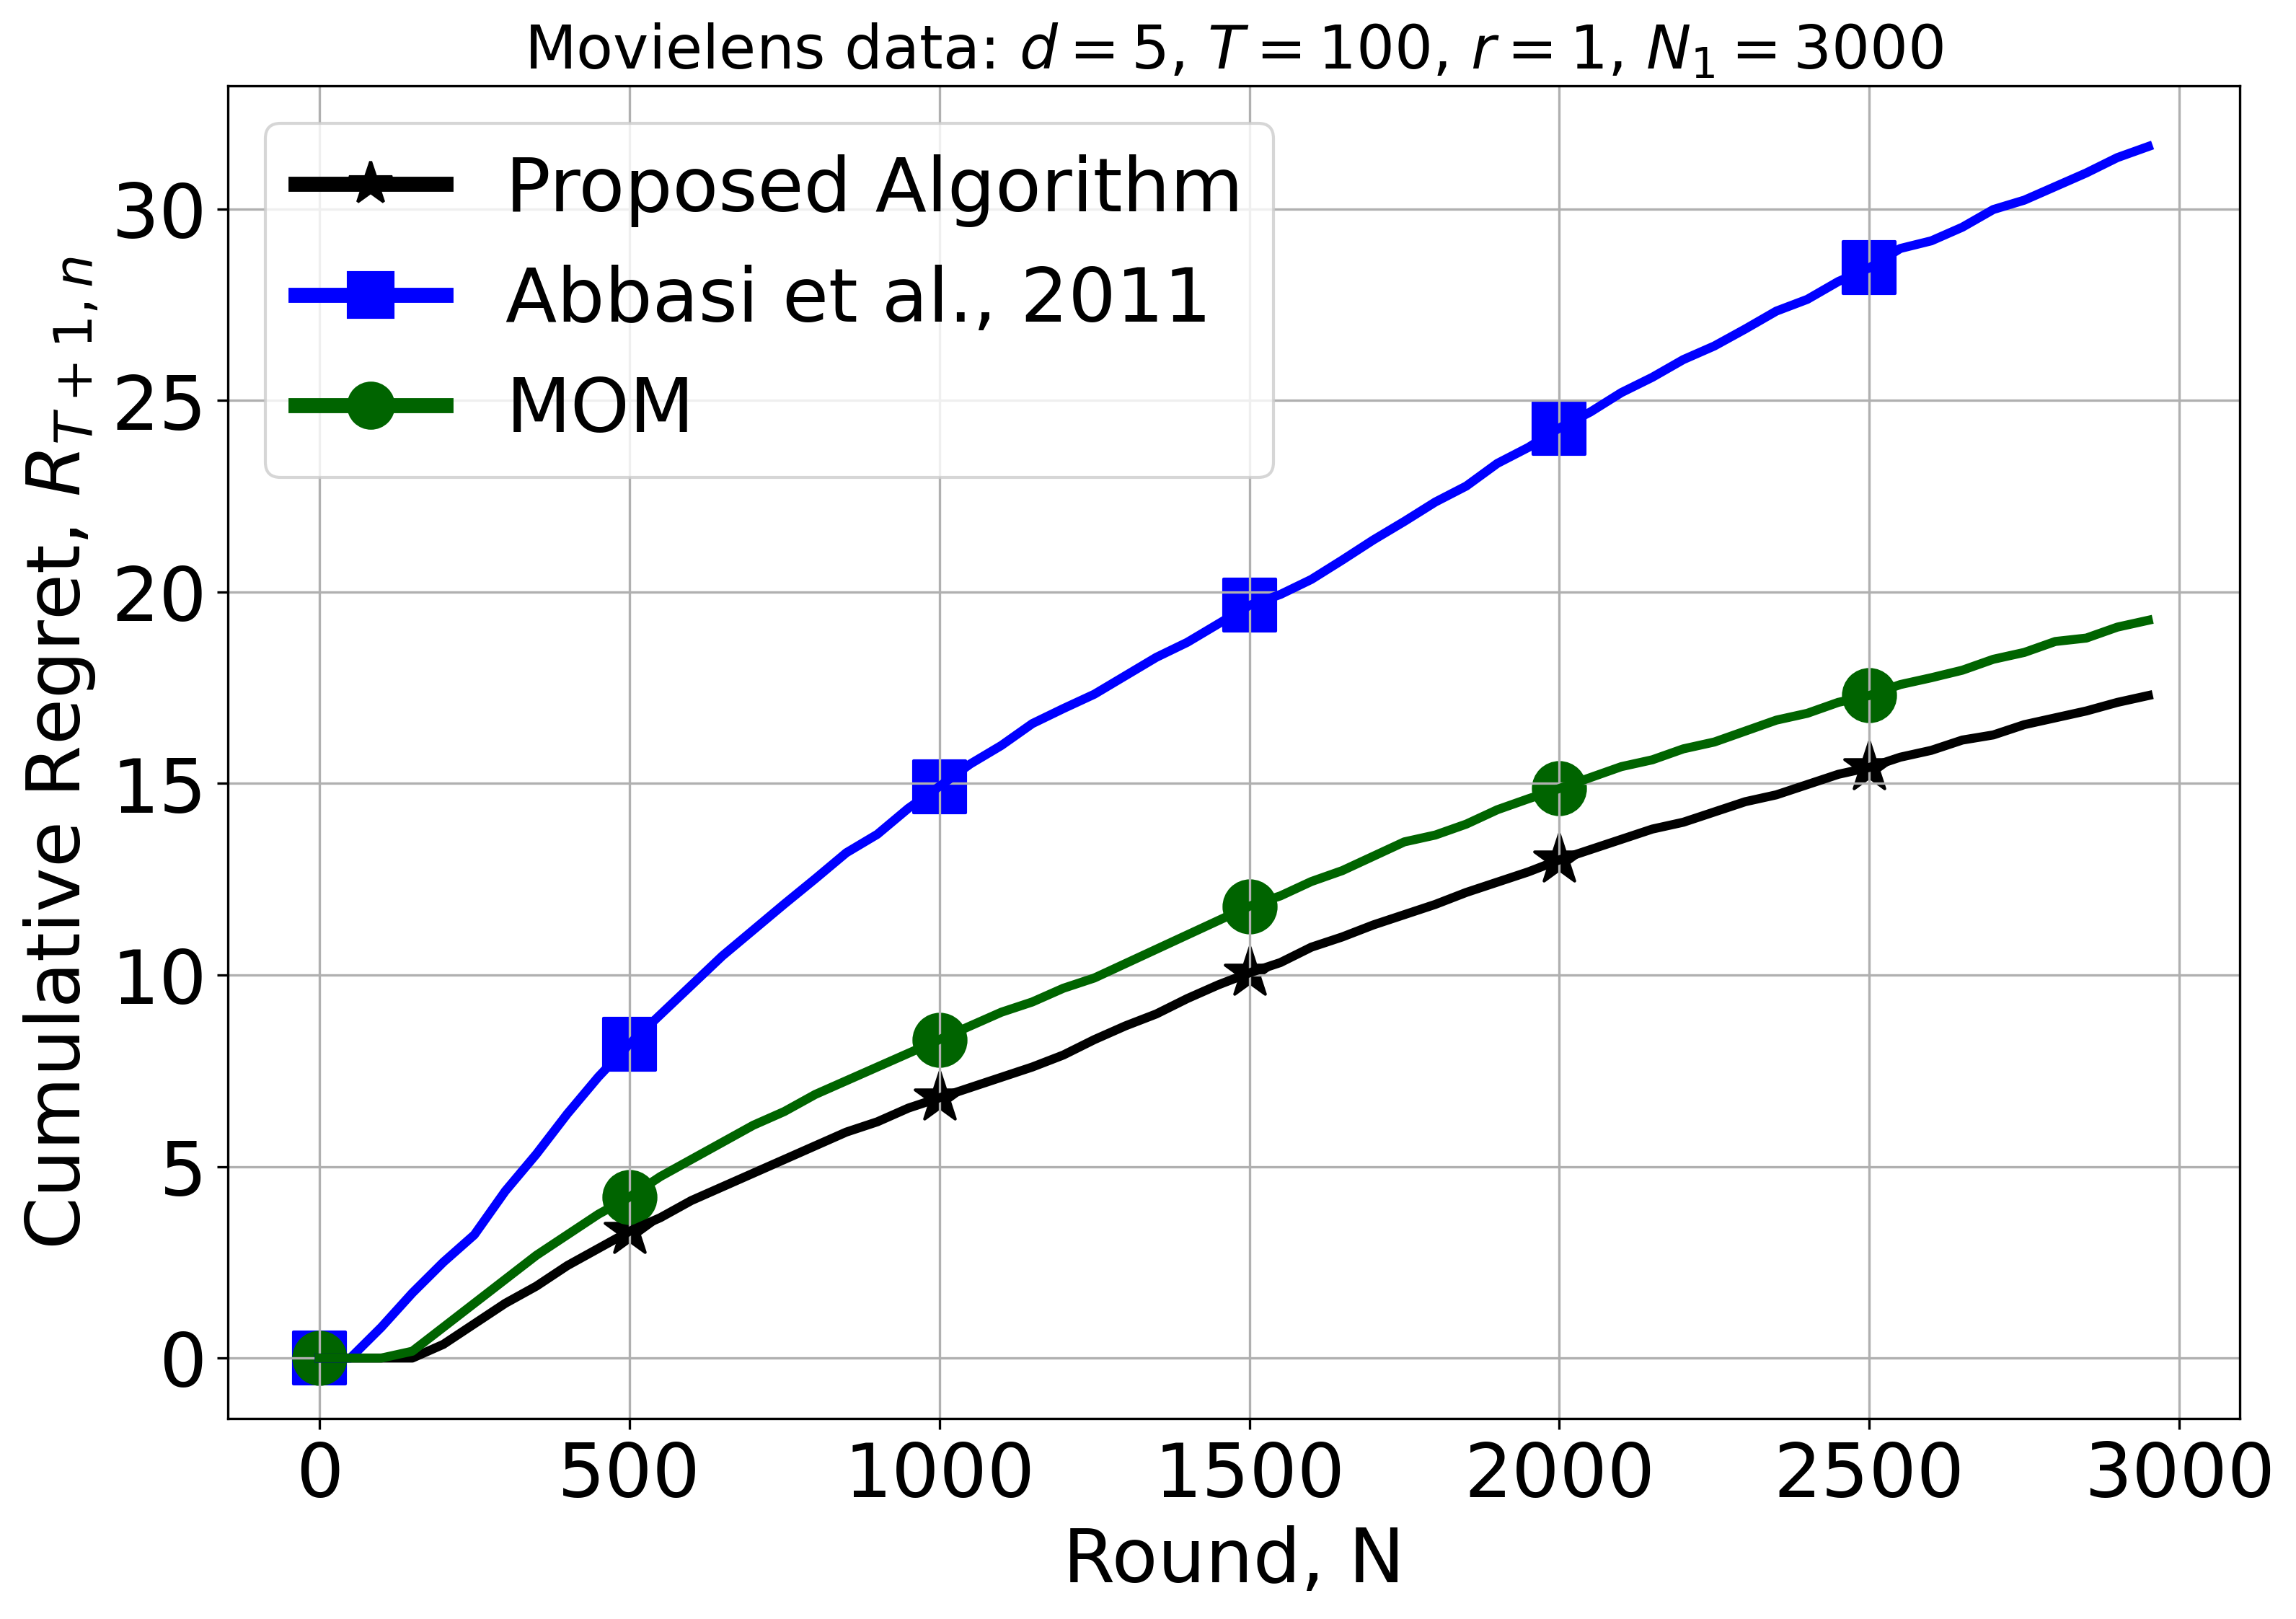

In [13]:
plt.figure(figsize=(12, 8), dpi = 300)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

colors = (['black', 'blue', 'darkgreen', 'purple', 'darkred', 'grey'])
markers = ['*', 's', 'o', 'X', '^', 'P']

plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rc('legend', fontsize = 25)

x = [i for i in range(iterations - epoch_iter)]

plt.plot(x[::every_point_plot], CR_Trials[::every_point_plot], color = colors[0], linewidth = 3, label = 'Proposed Algorithm')
plt.scatter(x[::every_point_scatter], CR_Trials[::every_point_scatter], marker = markers[0], color = colors[0], s = 300, label = 'Proposed Algorithm')
plt.plot(x[::every_point_plot], CR_Trials_Abbasi[::every_point_plot], color = colors[1], linewidth = 3, label = 'Abbasi et al., 2011')
plt.scatter(x[::every_point_scatter], CR_Trials_Abbasi[::every_point_scatter], marker = markers[1], color = colors[1], s = 300, label = 'Abbasi et al., 2011')
plt.plot(x[::every_point_plot], CR_Trials_MOM[::every_point_plot], color = colors[2], linewidth = 3, label = 'MOM')
plt.scatter(x[::every_point_scatter], CR_Trials_MOM[::every_point_scatter], marker = markers[2], color = colors[2], s = 300, label = 'MOM')

legend_elements = [mlines.Line2D([0], [0], color = colors[0], lw = 5, label = 'Proposed Algorithm', marker = markers[0], markersize = 15),
                   mlines.Line2D([0], [0], color = colors[1], lw = 5, label = 'Abbasi et al., 2011', marker = markers[1], markersize = 15),
                   mlines.Line2D([0], [0], color = colors[2], lw = 5, label = 'MOM', marker = markers[2], markersize = 15)]

plt.grid(True)
plt.xlabel('Round, N', fontsize = 25)
plt.ylabel(r'Cumulative Regret, $R_{T+1,n}$', fontsize = 25)
plt.legend(handles=legend_elements)
plt.title(r'Movielens data: $d=5$, $T=100$, $r=1$, $N_1=3000$', fontsize = 20)
plt.savefig('meta_Movielens.pdf', dpi = 600, bbox_inches = 'tight')
plt.show()
plt.close()

In [14]:
np.save('CR_Trials_Proposed.npy', np.array(CR_Trials, dtype=object))
np.save('CR_Trials_Abbasi.npy', np.array(CR_Trials_Abbasi, dtype=object))
np.save('CR_Trials_MOM.npy', np.array(CR_Trials_MOM, dtype=object))